In [1]:
# libraries
import ndjson
import json
import pandas as pd
import numpy as np
import altair as alt
import gzip
import random
import csv
import re

import matplotlib.pyplot as plt
import seaborn as sns
from pywaffle import Waffle

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download("opinion_lexicon")
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import opinion_lexicon

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sa = SentimentIntensityAnalyzer()
sa.lexicon

from imblearn.under_sampling import RandomUnderSampler 

%matplotlib inline

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\hewin\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hewin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hewin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hewin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# opening gzipped NDJSON file
with gzip.open("Video_Games_5.json.gz", "rb") as f:
    data = ndjson.load(f)

In [3]:
df_raw = pd.DataFrame(data)
df_raw.head(2)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN,NaN,NaN
1,4.0,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN


## <center>A Pinch of Salt?</center> 

Unscrupulous sellers are using a range of tactics to evade detection on Amazon and mislead shoppers with fake reviews, a Which? investigation has revealed. After analysing thousands of reviews across hundreds of products, evidence emerged of exactly how Amazon sellers have found intricate ways to ‘game’ the system. 

We found: Products with hundreds of ‘variations’, being used to create large numbers of positive reviews. Old products whose positive reviews were being used to promote new, unrelated products. Facebook review groups are ‘back’: tens of thousands populate a Facebook community of incentivised reviewers, posting hundreds of products per hour. Amazon customers whose user accounts have been hacked and used to publish thousands of fake reviews.

Read more: https://www.which.co.uk/news/2019/07/exposed-the-tricks-sellers-use-to-post-fake-reviews-on-amazon/ - Which?

In [4]:
# prep total counts 
df_total = df_raw.groupby('overall').size().reset_index(name='counts')
df_total['overall'] = df_total['overall'].astype('int')

# prep verified total counts
df_verified = df_raw[df_raw['verified'] == True]
df_verified = df_verified.groupby('overall').size().reset_index(name='counts')
df_verified['verified_counts'] = df_verified['counts'] 
df_verified = df_verified.drop('counts', axis=1)
df_verified['overall'] = df_verified['overall'].astype('int')

# join verified and total counts
df = pd.merge(df_total, df_verified, how='left', on='overall')

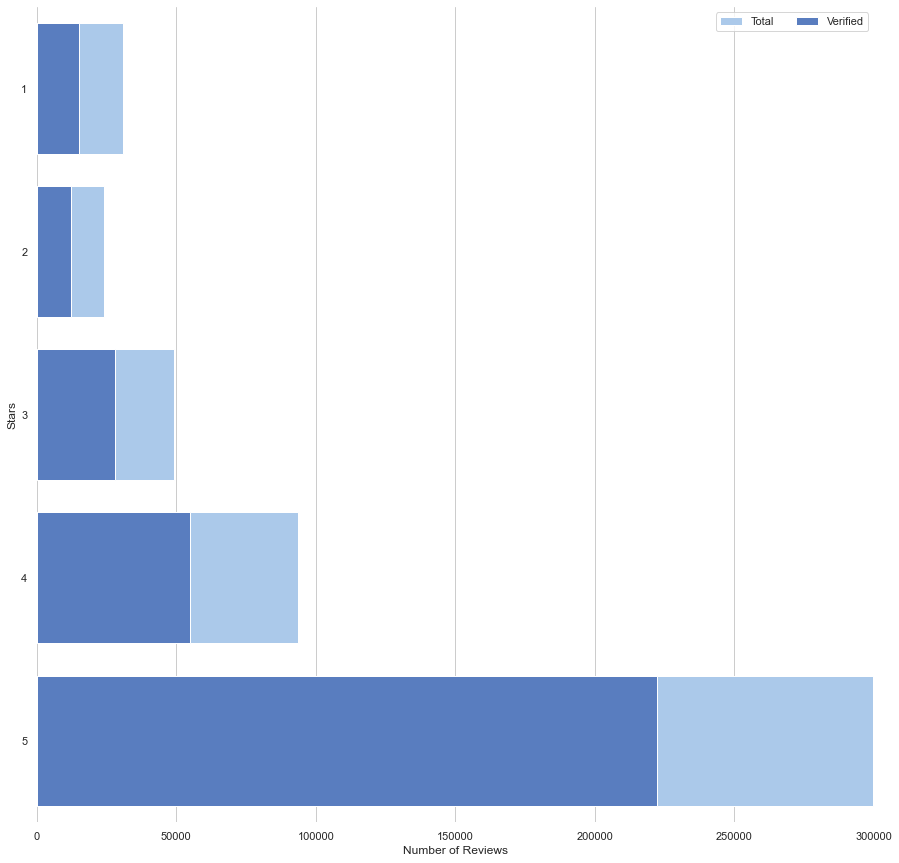

In [5]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Plot the total reviews
sns.set_color_codes("pastel")
sns.barplot(x="counts", y="overall", data=df,
            label="Total", color="b", orient='h')

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="verified_counts", y="overall", data=df,
            label="Verified", color="b", orient='h')

# Add a legend and informative axis label
ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set(ylabel="Stars",
       xlabel="Number of Reviews",
       xlim=(0, 300000))
sns.despine(left=True, bottom=True)

In [6]:
df['% of total reviews'] = ((df['counts'] / df['counts'].sum())*100).round(2).astype(str) + '%'
df['% verified'] = ((df['verified_counts'] / df['counts'])*100).round(2).astype(str) + '%'
print(df)

   overall  counts  verified_counts % of total reviews % verified
0        1   30883            15202              6.21%     49.22%
1        2   24135            12120              4.85%     50.22%
2        3   49146            27978              9.88%     56.93%
3        4   93654            54886             18.82%     58.61%
4        5  299759           222459             60.24%     74.21%


From the above analysis it is apparent that four/five star reviews make-up a large proportion of the reviews in this data and the majority of these reviews are verified. 

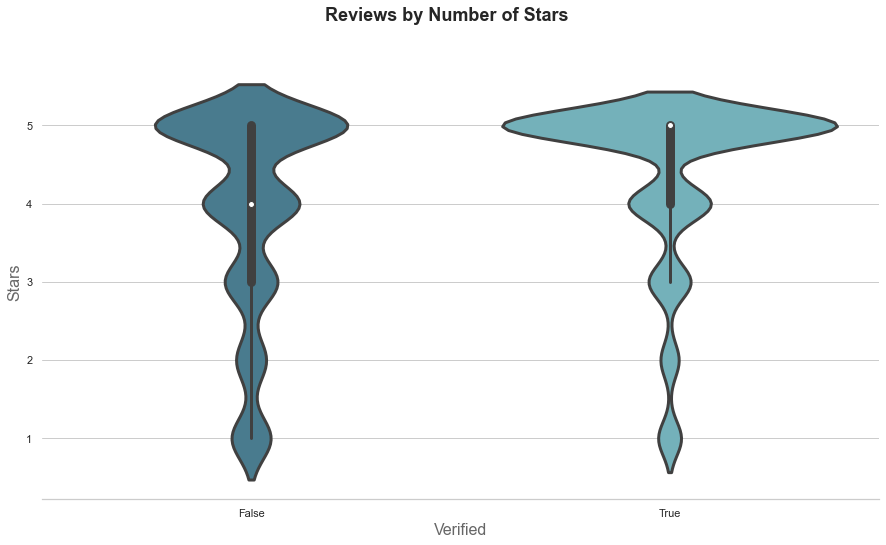

In [7]:
f, ax = plt.subplots(figsize=(15, 8))
with sns.color_palette("GnBu_d"):


# Show each distribution with both violins and points
    sns.violinplot(x="verified", y="overall",data=df_raw, palette="GnBu_d", inner="box", bw =.2, cut=2, linewidth=3, orient='v')

    sns.despine(left=True)

    f.suptitle('Reviews by Number of Stars', fontsize=18, fontweight='bold')
    ax.set_xlabel("Verified",size = 16,alpha=0.7)
    ax.set_ylabel("Stars",size = 16,alpha=0.7)

These violin plots show the relationship of unverified/verified reviews to number of stars. 

* the white dot represents the median.

* the thick black bar in the center represents the interquartile range.

* the thin black line represents the rest of the distribution, except for points that are determined to be “outliers” using a method that is a function of the interquartile range.

* On each side of the black line is a kernel density estimation to show the distribution shape of the data. Wider sections of the violin plot represent a higher probability that members of the population will take on the given value; the skinnier sections represent a lower probability.

The results for verified reviews are:

* the median is 5 stars.
* the IQR is 1 star. 
* the range is 3 to 5 stars.
* very high probability that a review will have 5 stars overall. 

The results for unverified reviews are:

* the median is 4 stars.
* the IQR is 2 stars. 
* the range is 1 to 5 stars.
* high probability that a review will have 5 stars overall. 

## <center>bigger representative corpus</center> 

In [8]:
np.random.seed(42)
df_bigger_representative_corpus = df_raw.copy()
df_bigger_representative_corpus = df_bigger_representative_corpus[['overall', 'reviewText']]
df_bigger_representative_corpus = df_bigger_representative_corpus.rename(columns={'overall':'ratings', 'reviewText':'reviews'})
df_bigger_representative_corpus.iloc[[np.random.randint(100000) for _ in range(100000)]]

,ratings,reviews
15795,5.0,Arrived on time and grandkids love playing
860,3.0,great game.
76820,5.0,MGS3 is the best of the series and it's not re...
54886,5.0,This is without question the best controller I...
6265,1.0,The way the light/magnifier is mounted on the ...
...,...,...
57885,5.0,this was the greatest game!! the sound effect...
50577,5.0,"First of all, I know how most games in this ty..."
87556,4.0,I like the terrorist hunt mode either single p...
12117,5.0,A blast from the past. I went through two copi...


In [9]:
df_bigger_representative_corpus.to_csv('big_corpus.csv')

## <center>smaller balanced corpus</center> 

In [10]:
np.random.seed(42)

rus = RandomUnderSampler(sampling_strategy={1:1500,2:500,3:500,4:500, 5:1500},
                        random_state=42)

In [11]:
def resample(df, method):
    """Resamples df using method with .fit_resample()
    
    Args:
        df (DataFrame) Amazon review data
        method (object): resample with .fit_resample() method
    Returns:
            Resampled_df (DataFrame): Resampled DataFrame
            
    """
    processed_df = df
    target = processed_df.pop('overall')
    
    processed_x, processed_y = method.fit_resample(processed_df, target)
    
    cols = list(processed_df.columns) + ['overall']
    
    pdf_x = pd.DataFrame(processed_x, columns=processed_df.columns)
    pdf_y = pd.DataFrame(processed_y, columns=['overall'])
    resampled_df = pd.concat([pdf_x, pdf_y], axis=1)
    
    return resampled_df 

In [12]:
rus_resampled = resample(df_raw, rus)
df_smaller_balanced_corpus = rus_resampled
print(df_smaller_balanced_corpus.shape)
print(df_smaller_balanced_corpus.overall.value_counts())

(4500, 12)
5.0    1500
1.0    1500
4.0     500
3.0     500
2.0     500
Name: overall, dtype: int64


In [13]:
df_smaller_balanced_corpus = df_smaller_balanced_corpus[['overall', 'reviewText']]
df_smaller_balanced_corpus = df_smaller_balanced_corpus.rename(columns={'overall':'ratings', 'reviewText':'reviews'})
df_smaller_balanced_corpus

,ratings,reviews
0,1.0,Recently UBISOFT had to settle a huge class-ac...
1,1.0,"code didn't work, got me a refund."
2,1.0,"these do not work at all, all i get is static ..."
3,1.0,well let me start by saying that when i first ...
4,1.0,"Dont waste your money, you will just end up us..."
...,...,...
4495,5.0,"Nice long micro USB cable, battery lasts a lon..."
4496,5.0,I've been having a great time with this game. ...
4497,5.0,d
4498,5.0,"Really pretty, funny, interesting game. Works ..."


In [14]:
df_smaller_balanced_corpus.to_csv('small_corpus.csv')